In [8]:
import h5py

def load_h5py_file(file_path):
    data = {
        'neural_features': [],
        'n_time_steps': [],
        'seq_class_ids': [],
        'seq_len': [],
        'transcriptions': [],
        'sentence_label': [],
        'session': [],
        'block_num': [],
        'trial_num': [],
    }
    # Open the hdf5 file for that day
    with h5py.File(file_path, 'r') as f:

        keys = list(f.keys())

        # For each trial in the selected trials in that day
        for key in keys:
            g = f[key]

            neural_features = g['input_features'][:]
            n_time_steps = g.attrs['n_time_steps']
            seq_class_ids = g['seq_class_ids'][:] if 'seq_class_ids' in g else None
            seq_len = g.attrs['seq_len'] if 'seq_len' in g.attrs else None
            transcription = g['transcription'][:] if 'transcription' in g else None
            sentence_label = g.attrs['sentence_label'][:] if 'sentence_label' in g.attrs else None
            session = g.attrs['session']
            block_num = g.attrs['block_num']
            trial_num = g.attrs['trial_num']

            data['neural_features'].append(neural_features)
            data['n_time_steps'].append(n_time_steps)
            data['seq_class_ids'].append(seq_class_ids)
            data['seq_len'].append(seq_len)
            data['transcriptions'].append(transcription)
            data['sentence_label'].append(sentence_label)
            data['session'].append(session)
            data['block_num'].append(block_num)
            data['trial_num'].append(trial_num)
    return data


In [21]:
from pathlib import Path
import sys
import pandas as pd

# 改成你的 repo 根目錄
repo_root = Path(r"c:\Users\super\OneDrive\桌面\Data_Mining\Own_project\brain-to-text")
sys.path.append(str(repo_root))

# 測試其中一個hdf
h5_path = Path(r"C:\Users\super\OneDrive\桌面\Data_Mining\Own_project\brain-to-text\data\t15_copyTask_neuralData\hdf5_data_final\t15.2023.08.11\data_train.hdf5")
test_trials = load_h5py_file(str(h5_path))
test_df = pd.DataFrame(test_trials)

test_df.head()        # 看前五筆
 



,neural_features,n_time_steps,seq_class_ids,seq_len,transcriptions,sentence_label,session,block_num,trial_num
0,"[[2.3076649, -0.78699756, -0.64687246, -0.5465...",321,"[7, 28, 17, 24, 40, 17, 31, 40, 20, 21, 25, 29...",14,"[66, 114, 105, 110, 103, 32, 105, 116, 32, 99,...",Bring it closer.,t15.2023.08.11,2,0
1,"[[-0.51709145, -0.70207363, -0.64330804, -0.48...",481,"[22, 6, 40, 14, 2, 22, 3, 21, 18, 40, 17, 38, ...",19,"[77, 121, 32, 102, 97, 109, 105, 108, 121, 32,...",My family is closer.,t15.2023.08.11,2,1
2,"[[0.95464545, -0.6912571, 2.5334082, -0.459320...",480,"[36, 3, 31, 40, 9, 34, 40, 10, 13, 40, 21, 6, ...",14,"[87, 104, 97, 116, 32, 100, 111, 32, 116, 104,...",What do they like?,t15.2023.08.11,2,2
3,"[[-0.4997814, -0.6836047, -0.6305947, 1.260037...",502,"[16, 5, 40, 17, 38, 40, 10, 2, 31, 40, 15, 33,...",14,"[72, 111, 119, 32, 105, 115, 32, 116, 104, 97,...",How is that good?,t15.2023.08.11,2,3
4,"[[-0.4850082, -0.66607094, -0.62398034, -0.433...",402,"[23, 18, 9, 40, 16, 11, 21, 27, 40, 16, 18, 28...",13,"[78, 101, 101, 100, 32, 104, 101, 108, 112, 32...",Need help here?,t15.2023.08.11,2,4


In [34]:
from pathlib import Path
import re
import pandas as pd

ROOT = Path(r"C:\Users\super\OneDrive\桌面\Data_Mining\Own_project\brain-to-text\data\t15_copyTask_neuralData\hdf5_data_final")
DATE_RE = re.compile(r"t\d+\.(\d{4}\.\d{2}\.\d{2})", re.IGNORECASE)

def _to_row_list(trials):
    """
    將 load_h5py_file 的輸出正規化為 list[dict]。
    - 若已是 list[dict]：直接回傳
    - 若是 dict[str -> list/array]：轉成逐列的 list[dict]
    """
    if isinstance(trials, list):
        # 例如: [{'key':..., 'session':..., ...}, ...]
        return trials

    if isinstance(trials, dict):
        # 例如: {'neural_features':[...], 'session':[...], ...}
        # 找出每欄長度（以最長者為準，不足的補 None）
        lengths = [len(v) for v in trials.values() if hasattr(v, '__len__')]
        n = max(lengths) if lengths else 0
        rows = []
        for i in range(n):
            row = {}
            for k, v in trials.items():
                if hasattr(v, '__len__'):
                    row[k] = v[i] if i < len(v) else None
                else:
                    row[k] = v  # 標量
            rows.append(row)
        return rows

    raise TypeError(f"Unsupported trials type: {type(trials)}")

def load_all_train_trials(root: Path):
    rows = []
    files = sorted(root.glob("t15.*/data_train.hdf5"))
    print("train files:", len(files))
    for fp in files:
        trials_raw = load_h5py_file(str(fp))  # 你的函式
        trials = _to_row_list(trials_raw)     # 正規化成 list[dict]

        m = DATE_RE.search(fp.as_posix())
        source_date = m.group(1) if m else None

        for t in trials:
            r = dict(t)  # 現在安全了
            r["source_file"] = str(fp)
            r["source_basename"] = fp.name
            r["source_date"] = source_date
            rows.append(r)
    return rows

rows = load_all_train_trials(ROOT)

# 先做 metadata DataFrame（排除高維欄位，避免爆記憶體）
HIGH_DIM = {"neural_features", "seq_class_ids"}
train_meta = pd.DataFrame([{k: v for k, v in r.items() if k not in HIGH_DIM} for r in rows])

print(train_meta.shape)
print(train_meta.head())


train files: 45
(8072, 10)
   n_time_steps  seq_len                                     transcriptions  \
0           321       14  [66, 114, 105, 110, 103, 32, 105, 116, 32, 99,...   
1           481       19  [77, 121, 32, 102, 97, 109, 105, 108, 121, 32,...   
2           480       14  [87, 104, 97, 116, 32, 100, 111, 32, 116, 104,...   
3           502       14  [72, 111, 119, 32, 105, 115, 32, 116, 104, 97,...   
4           402       13  [78, 101, 101, 100, 32, 104, 101, 108, 112, 32...   

         sentence_label         session  block_num  trial_num  \
0      Bring it closer.  t15.2023.08.11          2          0   
1  My family is closer.  t15.2023.08.11          2          1   
2    What do they like?  t15.2023.08.11          2          2   
3     How is that good?  t15.2023.08.11          2          3   
4       Need help here?  t15.2023.08.11          2          4   

                                         source_file  source_basename  \
0  C:\Users\super\OneDrive\桌面\Data

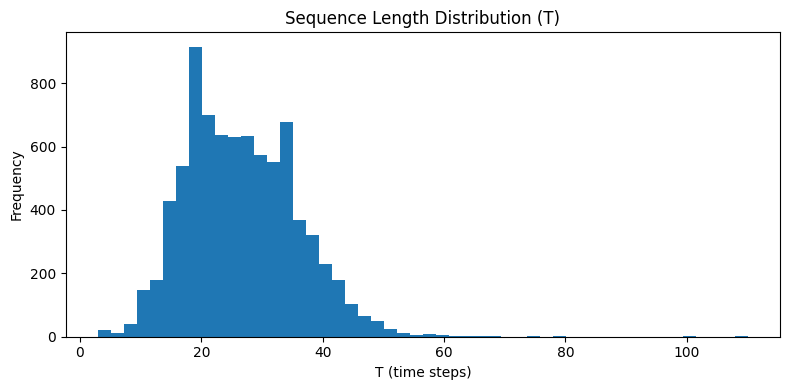

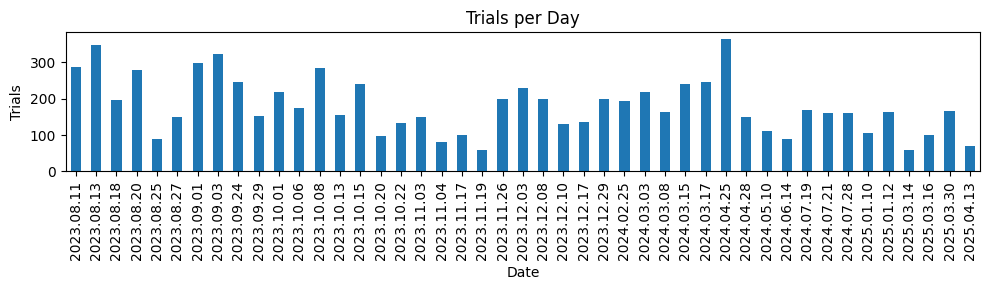

In [11]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

# 讀取前面建立的 train_meta
df_meta = train_meta

# 1) 序列長度分布（若 df_meta 有 seq_len；沒有就即時讀 T）
if 'seq_len' in df_meta.columns and df_meta['seq_len'].notna().any():
    seq_len = df_meta['seq_len'].dropna().astype(int)
else:
    # 從抽樣 trial 估計 T 分布，避免全量掃描
    sample_n = min(3000, len(df_meta))
    seq_len = []
    samp = df_meta.sample(sample_n, random_state=42)
    for _, r in samp.iterrows():
        with h5py.File(r['source_file'], 'r') as f:
            g = f[r['key']]
            if 'input_features' in g:
                X = g['input_features']
                if X.ndim == 2:
                    seq_len.append(X.shape[0])
    seq_len = pd.Series(seq_len)

ax = seq_len.plot(kind='hist', bins=50, figsize=(8,4), title='Sequence Length Distribution (T)')
ax.set_xlabel('T (time steps)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2) 每日 trial 數
if 'source_date' in df_meta.columns:
    ax = (df_meta['source_date'].value_counts().sort_index()
          .plot(kind='bar', rot=90, figsize=(10,3), title='Trials per Day'))
    ax.set_xlabel('Date')
    ax.set_ylabel('Trials')
    plt.tight_layout()
    plt.show()

